In [1]:
# LOAD LIBRARIES
from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table, join
import agama
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import (BSpline,Fourier,Monomial)
from skfda.exploratory.visualization import FPCAPlot

plt.rcParams['font.size'] = 12

# DATA LOADER
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    oo_age = None
    oo_orbit = None
    oo_actions = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)
            z=None
            VZ=None

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        indphi&=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,z,VR,Vphi,VZ,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=True, source_id=False):
        if self.oo == None or self.new != new:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo
        print(oo.keys())
        
        VR,Vphi,VZ,x,y,z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        sid = np.array(oo['source_id'], dtype=np.int64)
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,sid=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],sid[indphi]
        
        DATA = True
        if source_id:
            return x,y,z,VR,Vphi,VZ,R,Lz,phi,sid
        return x,y,z,VR,Vphi,VZ,R,Lz,phi
    
    def load_data_ages(self, xmin=1500, xmax=3500, phi_range=0.4):
        #path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
        #oo = Table.read(path, format='fits')
        #ages = Table.read('o_galpy/agesGDR3RVS_reduced.fits')
        #joined = join(oo,ages,keys='source_id')
        #print(joined.colnames)
        #print(joined)
        #joined.write('o_galpy/agesGDR3RVS_joined.fits', format='fits')
        #return
        #path = 'o_galpy/agesGDR3RVS_joined.fits'
        #oo = Table.read(path, format='fits')
        #indphi = ~np.isnan(np.array(oo['age']))
        #clean = oo[indphi]
        #clean.write('o_galpy/agesGDR3RVS_clean.fits', format='fits')
        #return
        
        if self.oo_age is None:
            path = 'o_galpy/agesGDR3RVS_clean.fits'
            self.oo_age = Table.read(path, format='fits')
        oo = self.oo_age

        VR,Vphi,VZ,x,y,z,R,phi,age,age_error=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['age'],oo['age_error']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],age[indphi],age_error[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,age,age_error
    
    def load_data_orbits(self, xmin=1500, xmax=3500, phi_range=0.4):
        if self.oo_orbit is None:
            path = 'o_galpy/orbitsGDR3RVS_joined.fits'
            self.oo_orbit = Table.read(path, format='fits')
        oo = self.oo_orbit

        VR,Vphi,VZ,x,y,z,R,phi,Zmax,Jz,Jr=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi'],oo['Zmax_med_dgeo'],oo['Jz_med_dgeo'],oo['Jr_med_dgeo']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],Zmax[indphi],Jz[indphi],Jr[indphi]
        
        DATA = True
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,Zmax,Jz,Jr
    
    def load_data_actions(self, xmin, xmax, phi_range):
        if self.oo_actions is None:
            self.oo_actions = Table.read('actions_joined.fits', format='fits')
        tj = self.oo_actions
        
        lst = ('source_id','X','Y','Z','VR','Vphi','VZ','R','phi', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi')
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (tj[i] for i in lst)
        Lz = -R * Vphi
        phi = -phi
        Vphi = -Vphi
        
        indphi = ~np.isnan(Jr)
        indphi &= abs(phi) < phi_range
        indphi &= (Lz>xmin)&(Lz<xmax)
        source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = (i[indphi] for i in (source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz))
        
        return source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz
    
l = Loader()

# AUXILIARY_FUNCTIONS

def smooth_bins(x, y, xmin, xmax, binsize, calc_error=False,median=False):
    binsLZ=np.arange(xmin,xmax,binsize)
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    error = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) == 0:
                means.append(0)
                error.append(0)
            else:
                means.append(means[-1])
                error.append(error[-1])
        else:
            if median:
                if np.isnan(np.ma.median(rel)):
                    print(rel)
                means.append(np.ma.median(rel))
            else:
                means.append(np.mean(rel))
            err = np.std(rel)/np.sqrt(len(rel))
            error.append(err)
    ypol = np.array(means)
    error = np.array(error)
    if calc_error:
        return xpol, ypol, error
    return xpol, ypol


(array([[ 0.00931113, -0.7848131 ,  0.04368979],
       [ 0.30519562, -2.59339449,  0.33635541],
       [ 0.14264169,  0.11744246, -0.08540614],
       ...,
       [-1.11445415,  2.72846135, -0.52975465],
       [-0.12999963, -0.2150614 ,  0.09239034],
       [-0.72602297, -0.08528221, -0.09688526]]), array([9.98552721e-06, 9.98552721e-06, 9.98552721e-06, ...,
       9.98552721e-06, 9.98552721e-06, 9.98552721e-06]))


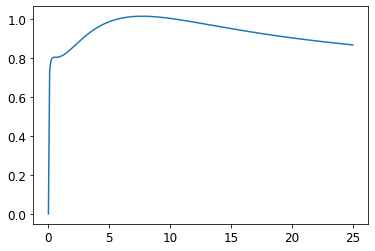

In [8]:
# create three components of a composite galaxy potential
pot_bulge = agama.Potential(type='Sersic', mass=1,
scaleRadius=1, sersicIndex=4, axisRatioZ=0.6)
pot_disc = agama.Potential(type='Disk', mass=4,
scaleRadius=3, scaleHeight=0.5)
pot_halo = agama.Potential(type='NFW', mass=25,
scaleRadius=10)
pot = agama.Potential(pot_bulge, pot_disc, pot_halo)
# represent the density profile as a collection of particles
snap = pot_bulge.sample(100000)
print(snap)
# create a potential from this N−body snapshot
pot_nbody = agama.Potential(type='Multipole',
particles=snap, symmetry='Axisymmetric')
# choose the grid in radius to plot the profiles
r=np.linspace(0.0, 25.0, 250)
xyz=np.column_stack((r, r*0, r*0))
# circular velocity as a function of radius: total...
vcirc_total = np.sqrt(-r * pot.force(xyz)[:,0])
plt.plot(r, vcirc_total, label='Total')

63.90013551569192
/tmp/ipykernel_10465/1220407314.py:36: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(-deriv[:,0] - 3*force[:,0]/r)



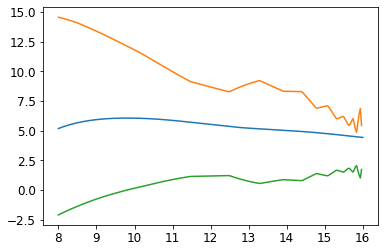

In [18]:

TIME = 3.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,z,VR,Vphi,VZ,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

_,_,_,Vx,Vy,_ = cyl2cart(R,phi,z,VR,Vphi,VZ)

agama.setUnits(length=1, velocity=1, mass=1) 
pos = np.dstack((x,y,z,Vx,Vy,VZ))[0]
mass = np.ones(len(x)) * 12000

#pot_nbody = agama.Potential(type='Multipole', particles=(pos,mass), symmetry='Axisymmetric')
#pot_nbody = agama.Potential(type='Multipole', particles=(pos,mass))
#pot_nbody = agama.Potential(type='CylSpline', particles=(pos,mass))
pot_nbody = agama.Potential(type='CylSpline', particles=(pos,mass), symmetry='Axisymmetric')

#r = np.linspace(0,20)
#points = np.column_stack((r, r*0, r*0)) # a N × 3 array
#force,deriv = pot_nbody.forceDeriv(points) # ⇒ N × 3 and N × 6 arrays
#kappa = np.sqrt(-deriv[:,0] - 3*force[:,0]/r) # radial epicyclic frequency κ
#nu = np.sqrt(-deriv[:,2]) # vertical epicyclic frequency ν
#plt.plot(r, np.sqrt(-r*pot_nbody.force(points)[:,0]))
#for pot in pot_nbody: plt.plot(r, np.sqrt(-r*pot.force(points)[:,0]))

r=np.linspace(8.0, 16.0, 250)
xyz=np.column_stack((r, r*0, r*0))
vcirc = np.sqrt(-r * pot_nbody.force(xyz)[:,0])
#plt.plot(r, vcirc)

print(np.mean(vcirc))

w = vcirc/r
force,deriv = pot_nbody.forceDeriv(xyz)
k = np.sqrt(-deriv[:,0] - 3*force[:,0]/r)
#dR = np.gradient(r)
#dw2 = np.gradient(w**2)
#k = np.sqrt(r * dw2/dR + 4 * w**2)
freq = w - k/2
plt.plot(r, w)
plt.plot(r,k)
plt.plot(r, freq)

#
#ffreq = interpolate.interp1d(r, freq, 'linear')
#def phiR(R, t):
#    return ffreq(R)*t

#xl = []
#yl = []
#xl2 = []
#yl2 = []
#t = 0.5
#for ri in r:
#    xl.append(ri*np.sin(phiR(ri,t)))
#    yl.append(ri*np.cos(phiR(ri,t)))
#    xl2.append(ri*np.sin(phiR(ri,t)+np.pi))
#    yl2.append(ri*np.cos(phiR(ri,t)+np.pi))
#plt.plot(xl,yl,c='C0')
#plt.plot(xl2,yl2,c='C0')
#plt.axis('square')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

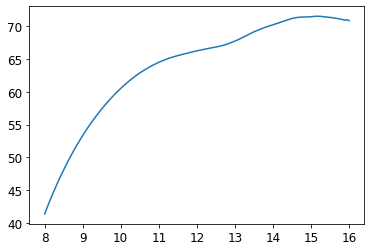

In [19]:
plt.plot(r, vcirc)

['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id']
237.05603644780055
[7.96392786 7.98396794 8.00400802 8.0240481 ] [239.99276414 239.99656318 239.99996923 240.00298608]


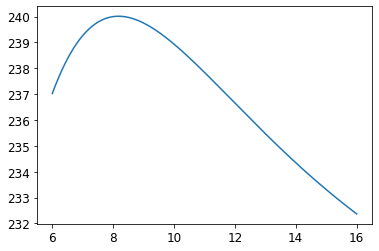

In [190]:

XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,z,VR,Vphi,VZ,R,Lz,phi,source_id=l.load_data(xmin=float('-inf'), xmax=float('inf'), phi_range=np.pi, source_id=True)
DATA = True

_,_,_,Vx,Vy,_ = cyl2cart(R,phi,z,VR,Vphi,VZ)
Vy = -Vy

agama.setUnits(length=1, velocity=1, mass=1) 
pos = np.dstack((x,y,z,Vx,Vy,VZ))[0]
mass = np.ones(len(x)) * 12000

pot_nbody = agama.Potential(file="McMillan17_sym.ini", scale=[(240/233.09)**2,1])

r=np.linspace(6.0, 16.0, 500)
xyz=np.column_stack((r, r*0, r*0))
vcirc = np.sqrt(-r * pot_nbody.force(xyz)[:,0])
plt.plot(r, vcirc)
#print(np.mean(vcirc))
#print(r[98:102], vcirc[98:102])

#w = vcirc/r
#force,deriv = pot_nbody.forceDeriv(xyz)
#k = np.sqrt(-deriv[:,0] - 3*force[:,0]/r)
#freq = w - k/2
#plt.plot(r, w)
#plt.plot(r,k)
#plt.plot(r, freq)


In [2]:

XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,z,VR,Vphi,VZ,R,Lz,phi,source_id=l.load_data(xmin=float('-inf'), xmax=float('inf'), phi_range=np.pi, source_id=True)
DATA = True
#Vphi = -Vphi
phi = -phi

x2,y2,z2,Vx,Vy,Vz2 = cyl2cart(R,phi,z,VR,Vphi,VZ)

print(x, x2, sum(np.abs(x-x2)))
print(y, y2, sum(np.abs(y-y2)))
print(Vz2, VZ, sum(np.abs(Vz2-VZ)))


['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id']
[-7.43663861 -9.08302495 -6.18137314 ... -7.90254348 -2.36939283
 -7.34047046] [-7.43663861 -9.08302495 -6.18137314 ... -7.90254348 -2.36939283
 -7.34047046] 7.648574331496463e-09
[ 0.84425697 -0.31282662  0.50231314 ...  0.15801059  0.93239049
 -0.1169947 ] [ 0.84425697 -0.31282662  0.50231314 ...  0.15801059  0.93239049
 -0.1169947 ] 2.0111899928125466e-09
[ -24.34168587 -363.40816328   41.17208371 ... -192.24723709 -383.09085172
 -235.95115536] [ -24.34168587 -363.40816328   41.17208371 ... -192.24723709 -383.09085172
 -235.95115536] 0.0


In [3]:
af = agama.ActionFinderAxisymFudge(pot_nbody, interp=False)
act, ang, freq = af(pos, angles=True)
print(act)

AttributeError: module 'agama' has no attribute 'ActionFinderAxisymFudge'

In [ ]:
np.save('actions.npy',[act,ang,freq])
t = Table([source_id, act[:,0], act[:,1], act[:,2], ang[:,0], ang[:,1], ang[:,2], freq[:,0], freq[:,1], freq[:,2]],
          names=('source_id', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi'),
          dtype=(['int64']+['float64']*9))
t.write('actions.fits', format='fits', overwrite=True)

344 25397569


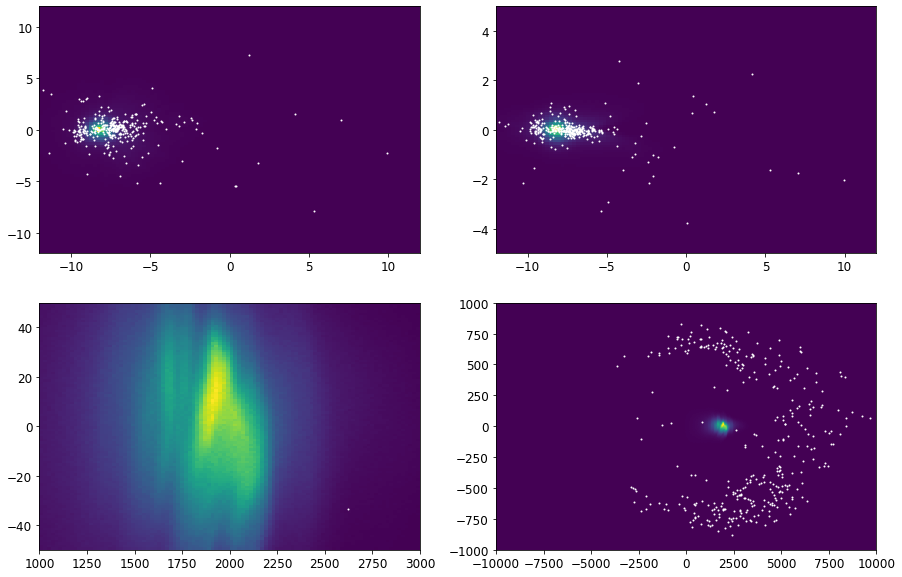

In [5]:
t = Table.read('actions.fits', format='fits')
source_id,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (t[i] for i in ('source_id', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi'))
isn = np.isnan(Jr)
fig, ax = plt.subplots(2,2,figsize=(15,10))
print(np.count_nonzero(isn),len(isn))
ax[0][0].hist2d(x, y, bins=100, range=[[-12,12],[-12,12]])
ax[0][0].scatter(x[isn], y[isn], s=1, c='w')
ax[0][1].hist2d(x, z, bins=100, range=[[-12,12],[-5,5]])
ax[0][1].scatter(x[isn], z[isn], s=1, c='w')

ax[1][0].hist2d(Lz, VR, bins=100, range=[[1000,3000],[-50,50]])
ax[1][0].scatter(Lz[isn], VR[isn], s=1, c='w')
ax[1][1].hist2d(Lz, VR, bins=500, range=[[-10000,10000],[-1000,1000]])
ax[1][1].scatter(Lz[isn], VR[isn], s=1, c='w')

In [6]:
path = 'o_galpy/orbitsGDR3RVS_joined.fits'
old = Table.read(path, format='fits')
print(old.keys())
old_and_new = join(old, t, keys='source_id')
del old
del t
import gc
gc.collect()

error = 2*np.abs(old_and_new['JR'] - old_and_new['Jr_med_dgeo']) / np.mean(old_and_new['JR'] + old_and_new['Jr_med_dgeo'])
error = error[~np.isnan(error)]
print('Mean relative error (JR):', np.mean(error))
print('Median relative error (JR):', np.median(error))
error = 2*np.abs(old_and_new['JZ'] - old_and_new['Jz_med_dgeo']) / np.mean(old_and_new['JZ'] + old_and_new['Jz_med_dgeo'])
error = error[~np.isnan(error)]
print('Mean relative error (JZ):', np.mean(error))
print('Median relative error (JZ):', np.median(error))



['VR', 'Vphi', 'VZ', 'X', 'Y', 'Z', 'R', 'phi', 'source_id', 'e_med_dgeo', 'Zmax_med_dgeo', 'Jr_med_dgeo', 'Jz_med_dgeo', 'rperi_med_dgeo', 'rapo_med_dgeo']
Mean relative error (JR): 0.14260893469700792
 /home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning:Warning: 'partition' will ignore the 'mask' of the MaskedColumn.

Median relative error (JR): 0.09287783231402742
Mean relative error (JZ): 0.1249125930053163
Median relative error (JZ): 0.009988262319973316


Text(0.5, 1.0, 'JPhi')

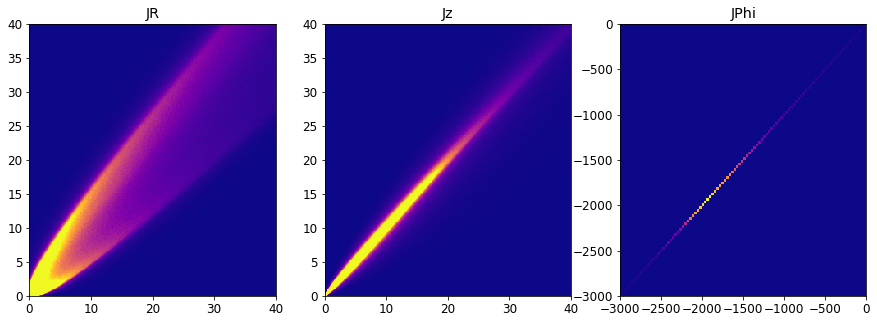

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist2d(old_and_new['JR'][~np.isnan(old_and_new['JR'])], old_and_new['Jr_med_dgeo'][~np.isnan(old_and_new['JR'])], bins=300, range=[[0,40],[0,40]], vmax=1500, cmap='plasma');
ax[1].hist2d(old_and_new['JZ'][~np.isnan(old_and_new['JZ'])], old_and_new['Jz_med_dgeo'][~np.isnan(old_and_new['JZ'])], bins=300, range=[[0,40],[0,40]], vmax=1500, cmap='plasma');
ax[2].hist2d(old_and_new['JPhi'][~np.isnan(old_and_new['JPhi'])], (old_and_new['R']*old_and_new['Vphi'])[~np.isnan(old_and_new['JPhi'])], bins=100, range=[[-3000,0],[-3000,0]], cmap='plasma');
#ax[0].plot([0,300],[0,300],c='w',lw=0.5)
#ax[1].plot([0,300],[0,300],c='w',lw=0.5)
#ax[2].plot([0,300],[0,300],c='w',lw=0.5)
ax[0].set_title('JR')
ax[1].set_title('Jz')
ax[2].set_title('JPhi')

In [8]:
old_and_new.write('actions_both.fits',overwrite=True)
#old_and_new = Table.read('actions_both.fits', format='fits')
#Table.from_pandas(old_and_new.to_pandas().sample(n=5000000)).write('actions_both_subsample.fits',overwrite=True)

In [17]:
#x,y,z,VR,Vphi,VZ,R,Lz,phi,source_id=l.load_data(xmin=float('-inf'), xmax=float('inf'), phi_range=np.pi, source_id=True)
#t1 = Table.read('o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits', format='fits')
#t = Table.read('actions.fits', format='fits')
#tj = join(t,t1,keys=['source_id'])
#tj.write('actions_joined.fits', format='fits')

tj = Table.read('actions_joined.fits', format='fits')
lst = ('source_id','X','Y','Z','VR','Vphi','VZ','R','phi', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi')
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (tj[i] for i in lst)
Lz = -R * Vphi
phi = -phi
Vphi = -Vphi
isn = np.isnan(Jr)
x,y,z,VR,Vphi,VZ,R,Lz,phi = (i[~isn] for i in (x,y,z,VR,Vphi,VZ,R,Lz,phi))
source_id,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (i[~isn] for i in (source_id,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi))

0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


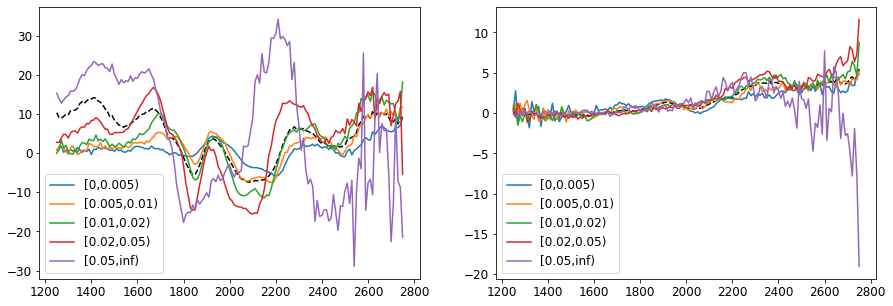

In [20]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(Lzc, VZ, XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), sum(ind))
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    nx, ny = smooth_bins(Lzc[ind], VZ[ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()

0 20 8406828 4001275
20 40 8406828 1897541
40 60 8406828 1020241
60 80 8406828 588078
80 100 8406828 350503


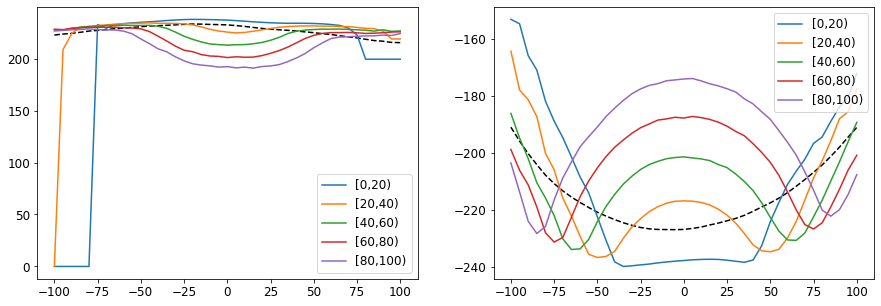

In [24]:
XMIN = 1250
XMAX = 2750
#source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

XMIN = -100
XMAX = 100
fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(VR, Vphi, XMIN, XMAX, 5)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(old_and_new['VR'], old_and_new['Vphi'], XMIN, XMAX, 5)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,20,40,60,80,100]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    print(low, high, len(ind), sum(ind))
    nx, ny = smooth_bins(VR[ind], Vphi[ind], XMIN, XMAX, 5)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    ind = (low <= old_and_new['Jr_med_dgeo']) & (old_and_new['Jr_med_dgeo'] < high)
    nx, ny = smooth_bins(old_and_new['VR'][ind], old_and_new['Vphi'][ind], XMIN, XMAX, 5)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()

(500.0, 3000.0)

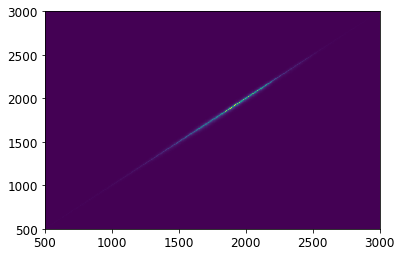

In [13]:
XMIN=0
XMAX=4000
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 
plt.hist2d(Lz, Jphi, bins=1000);
plt.xlim(500,3000)
plt.ylim(500,3000)

0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


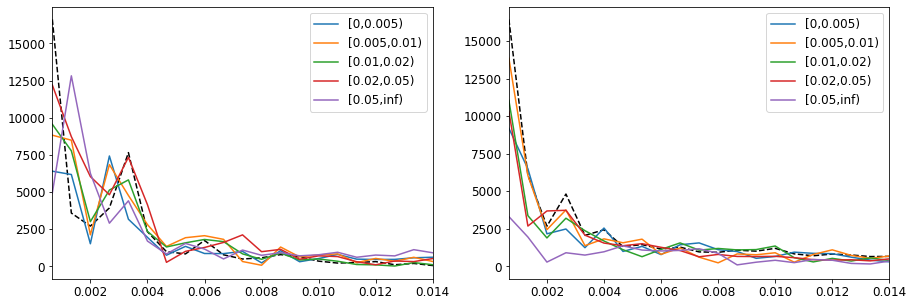

In [128]:
# Get an equispaced curve from a number of points
def curve_from_bins(nx, ny, N):
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    return xpol, ypol

# Perform Fourier transform on a curve
def fourier_from_curve(xpol, ypol):
    N = len(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((xpol[-1]-xpol[0]) / abs(xf * N))
    return xfr, yf

XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)
ax[0].plot(1/xfr,np.abs(yf),c='k',ls='--')
ax[0].set_xlim(1/max(xfr), 1/xfr[20])
nx, ny = smooth_bins(Lzc, VZ, XMIN, XMAX, 10)
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)
ax[1].plot(1/xfr,np.abs(yf),c='k',ls='--')
ax[1].set_xlim(1/max(xfr), 1/xfr[20])

lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), sum(ind))
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    xpol, ypol = curve_from_bins(nx, ny, N)
    xfr, yf = fourier_from_curve(xpol, ypol)
    ax[0].plot(1/xfr,np.abs(yf),label=f'[{low},{high})')
    nx, ny = smooth_bins(Lzc[ind], VZ[ind], XMIN, XMAX, 10)
    xpol, ypol = curve_from_bins(nx, ny, N)
    xfr, yf = fourier_from_curve(xpol, ypol)
    ax[1].plot(1/xfr,np.abs(yf),label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()



In [129]:
import emd

def do_emd(xpol, ypol):
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    sample_rate=1
    imf = emd.sift.sift(ypol)
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
    freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
    #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
    hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
    return hht_f, spec


XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
hht_f, spec = do_emd(xpol, ypol)
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
ax[0].plot(hhtfr, spec, c='k', ls='--')
ax[0].set_xlim(min(hhtfr), max(hhtfr))
ax[0].set_xscale('log')
nx, ny = smooth_bins(Lzc, VZ, XMIN, XMAX, 10)
xpol, ypol = curve_from_bins(nx, ny, N)
hht_f, spec = do_emd(xpol, ypol)
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
ax[1].plot(hhtfr, spec, c='k', ls='--')
ax[1].set_xlim(min(hhtfr), max(hhtfr))
ax[1].set_xscale('log')

lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), sum(ind))
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    xpol, ypol = curve_from_bins(nx, ny, N)
    hht_f, spec = do_emd(xpol, ypol)
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[0].plot(hhtfr,spec,label=f'[{low},{high})')
    nx, ny = smooth_bins(Lzc[ind], VZ[ind], XMIN, XMAX, 10)
    xpol, ypol = curve_from_bins(nx, ny, N)
    hht_f, spec = do_emd(xpol, ypol)
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[1].plot(hhtfr,spec,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff6aa65d4c0> (for post_execute):


KeyboardInterrupt: 

0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


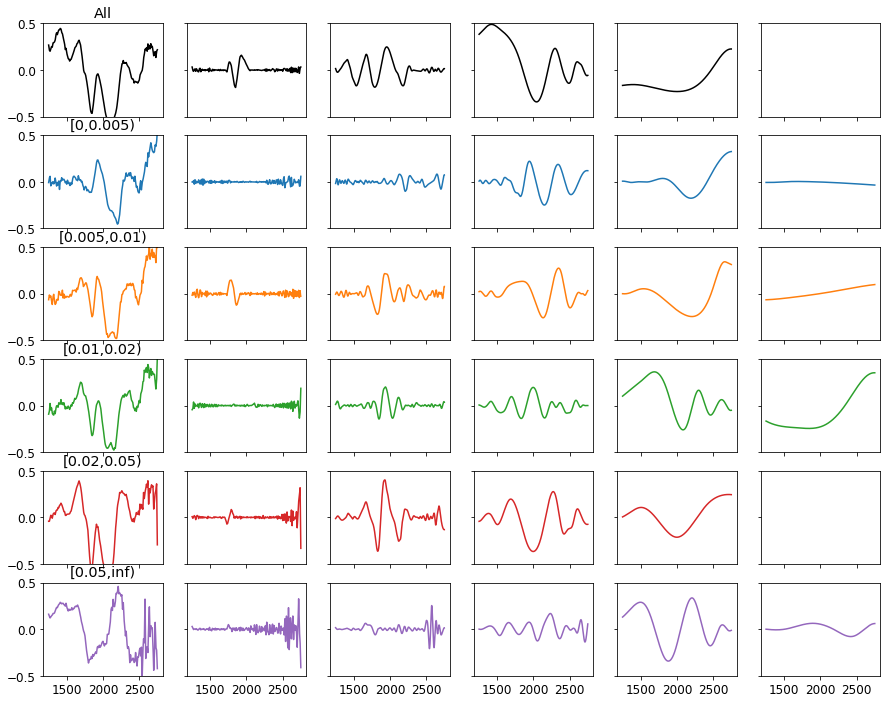

In [14]:
import emd

XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

YLIM = 0.5

fig, ax = plt.subplots(6,6,figsize=(15,12), sharex=True, sharey=True)
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
ax[0][0].plot(xpol, ypol, c='k')
ax[0][0].set_ylim(-YLIM,YLIM)
ax[0][0].set_title(f'All')
imf = emd.sift.sift(ypol)
for i in range(imf.shape[1]):
    ax[0][i+1].plot(xpol, imf[:,i], c='k')
    ax[0][i+1].set_ylim(-YLIM,YLIM)

lims = [0,.005,.01,.02,.05,float('inf')]
for j, (low, high) in enumerate(zip(lims[:-1],lims[1:])):
    ax[j+1][0].set_title(f'[{low},{high})')
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), np.count_nonzero(ind))
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    N = 100000
    xpol, ypol = curve_from_bins(nx, ny, N)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    ax[j+1][0].plot(xpol, ypol, c=f'C{j}')
    ax[j+1][0].set_ylim(-YLIM,YLIM)
    imf = emd.sift.sift(ypol)
    for i in range(imf.shape[1]):
        ax[j+1][i+1].plot(xpol, imf[:,i], c=f'C{j}')
        ax[j+1][i+1].set_ylim(-YLIM,YLIM)

# CORREU
plt.savefig('emd_actions.png')

[array([ 0.71048438,  1.45287597,  1.69502957,  0.18984434,  0.69436957,
        0.53544818,  0.86122921,  0.49246802,  0.60868217,  1.42482959,
        0.85242371,  0.15536853,  0.73069556,  0.34928829,  0.95943409,
       -0.38171617,  0.95446453,  0.89190291,  1.4783735 ,  1.08534527,
        1.21263432,  1.24537665,  1.05141729,  0.67683438,  0.83316735,
        0.44977478,  1.08244514,  0.62822177,  0.74027947,  0.26069219,
        0.24517859,  0.7125247 ,  0.45899608,  1.2425096 ,  1.65784406,
        1.73593922,  1.57149498,  1.49048292,  1.13517329,  1.14861872,
        1.00767958,  1.7873388 ,  1.28869735,  1.08574218,  1.16701289,
        0.83657678,  0.91288108,  0.32047189,  0.07881468, -0.46113364,
       -0.05293226,  0.10194597, -0.09265228, -0.60324493, -0.41281152,
       -0.54382361, -0.8195196 , -0.8618197 , -0.79313882, -0.82848492,
       -0.40951038,  0.08116193,  0.85234115,  1.47790104,  2.14057291,
        3.00624777,  3.81437613,  4.26831145,  4.29532033,  3.9

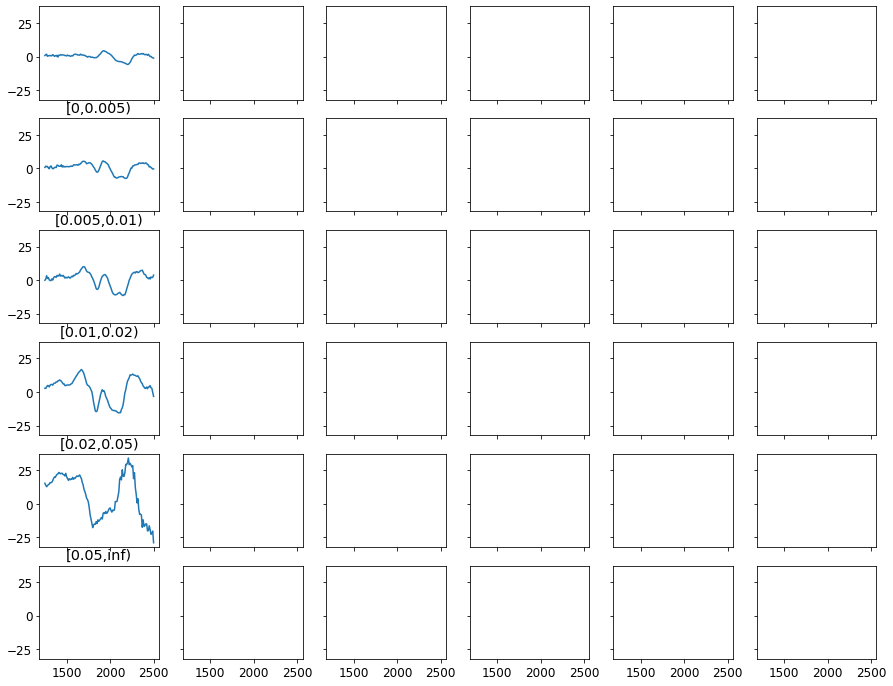

In [251]:
import emd

XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

YLIM = 0.5

fig, ax = plt.subplots(6,6,figsize=(15,12), sharex=True, sharey=True)
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
dat = []

lims = [0,.005,.01,.02,.05,float('inf')]
for j, (low, high) in enumerate(zip(lims[:-1],lims[1:])):
    ax[j+1][0].set_title(f'[{low},{high})')
    ind = (low <= Jrn) & (Jrn < high)
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    ax[j][0].plot(nx,ny)
    dat.append(ny)

print(dat)

0 1.5707963267948966 8406828 1892510
1.5707963267948966 3.141592653589793 8406828 2501307
3.141592653589793 4.71238898038469 8406828 2010977
4.71238898038469 6.283185307179586 8406828 2002034


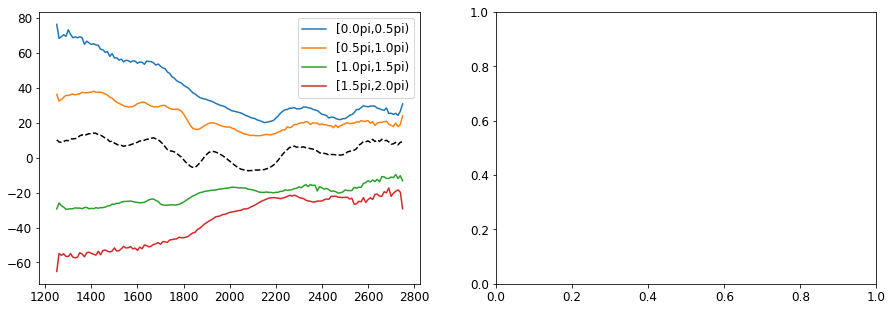

In [34]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

#plt.hist(angleR)

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

lims = [0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= angleR) & (angleR < high)
    print(low, high, len(ind), np.count_nonzero(ind))
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low/np.pi:.2}pi,{high/np.pi:.2}pi)')
ax[0].legend()
#ax[1].legend()

0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


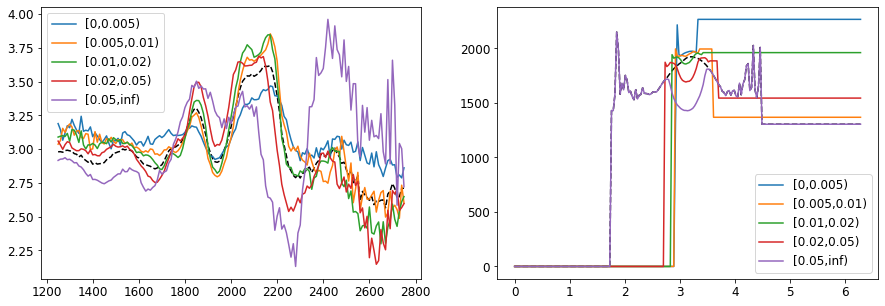

In [4]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, angleR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(anglePhi, Lz, 0, 2*np.pi, np.pi/100)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), np.count_nonzero(ind))
    nx, ny = smooth_bins(Lz[ind], angleR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    nx, ny = smooth_bins(anglePhi[ind], Lz[ind], 0, 2*np.pi, np.pi/100)
    #nx, ny = smooth_bins(Lz[ind], angleR[ind], 0, 2*np.pi, np.pi/100)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()

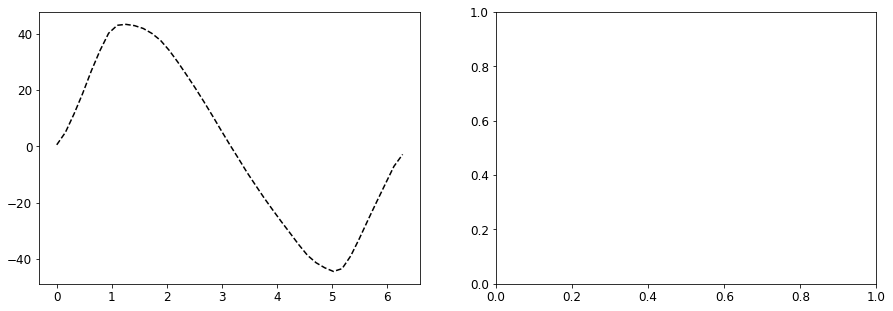

In [7]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(angleR, VR, 0, 2+np.pi, np.pi/20)

ax[0].plot(nx,ny,c='k',ls='--')



(array([115694., 180716., 125057.,  64028.,  40579.,  39943.,  62975.,
        162412., 279580., 145687.]),
 array([1.33745587e-06, 6.28319635e-01, 1.25663793e+00, 1.88495623e+00,
        2.51327453e+00, 3.14159282e+00, 3.76991112e+00, 4.39822942e+00,
        5.02654771e+00, 5.65486601e+00, 6.28318431e+00]),
 <BarContainer object of 10 artists>)

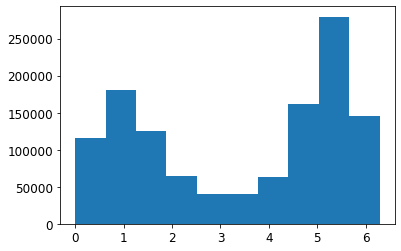

In [12]:

XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

plt.hist(angleR[(2000 < Lz) & (Lz < 2100)])

0 0.001 8406828 3083857
0.001 0.002 8406828 1482265
0.002 0.005 8406828 2003746
0.005 0.01 8406828 1065081
0.01 inf 8406828 771879
0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


(-3.0, 5.0)

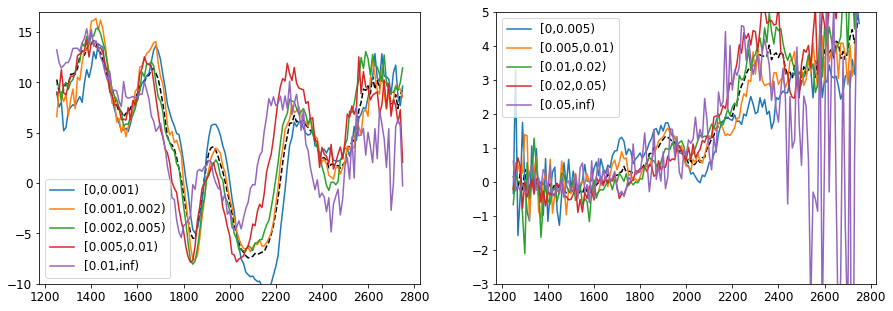

In [10]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(Lz, VZ, XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,.001,.002,.005,.01,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jzn) & (Jzn < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VZ[ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-3,5)

[array([ 0.71048438,  1.45287597,  1.69502957,  0.18984434,  0.69436957,
        0.53544818,  0.86122921,  0.49246802,  0.60868217,  1.42482959,
        0.85242371,  0.15536853,  0.73069556,  0.34928829,  0.95943409,
       -0.38171617,  0.95446453,  0.89190291,  1.4783735 ,  1.08534527,
        1.21263432,  1.24537665,  1.05141729,  0.67683438,  0.83316735,
        0.44977478,  1.08244514,  0.62822177,  0.74027947,  0.26069219,
        0.24517859,  0.7125247 ,  0.45899608,  1.2425096 ,  1.65784406,
        1.73593922,  1.57149498,  1.49048292,  1.13517329,  1.14861872,
        1.00767958,  1.7873388 ,  1.28869735,  1.08574218,  1.16701289,
        0.83657678,  0.91288108,  0.32047189,  0.07881468, -0.46113364,
       -0.05293226,  0.10194597, -0.09265228, -0.60324493, -0.41281152,
       -0.54382361, -0.8195196 , -0.8618197 , -0.79313882, -0.82848492,
       -0.40951038,  0.08116193,  0.85234115,  1.47790104,  2.14057291,
        3.00624777,  3.81437613,  4.26831145,  4.29532033,  3.9

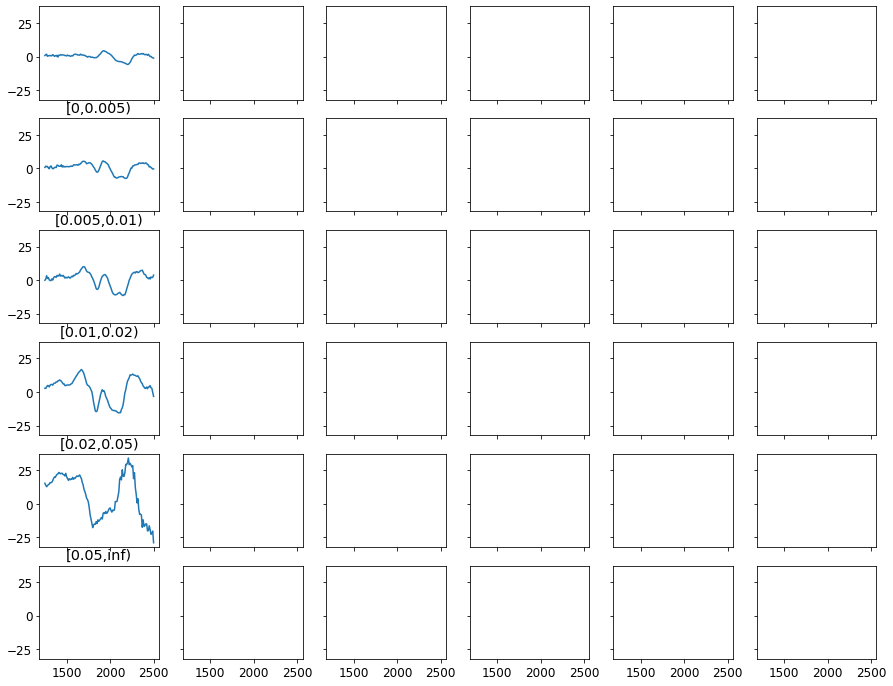

In [251]:
import emd

XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

YLIM = 0.5

fig, ax = plt.subplots(6,6,figsize=(15,12), sharex=True, sharey=True)
nx, ny = smooth_bins(Lzc, VR, XMIN, XMAX, 10)
dat = []

lims = [0,.005,.01,.02,.05,float('inf')]
for j, (low, high) in enumerate(zip(lims[:-1],lims[1:])):
    ax[j+1][0].set_title(f'[{low},{high})')
    ind = (low <= Jrn) & (Jrn < high)
    nx, ny = smooth_bins(Lzc[ind], VR[ind], XMIN, XMAX, 10)
    ax[j][0].plot(nx,ny)
    dat.append(ny)

print(dat)

0 1 8406828 1987512
1 2 8406828 1207311
2 5 8406828 2024617
5 10 8406828 1499114
10 inf 8406828 1688274
0 5 8406828 1306976
5 10 8406828 1082950
10 20 8406828 1611349
20 50 8406828 2479735
50 inf 8406828 1925818


(-3.0, 5.0)

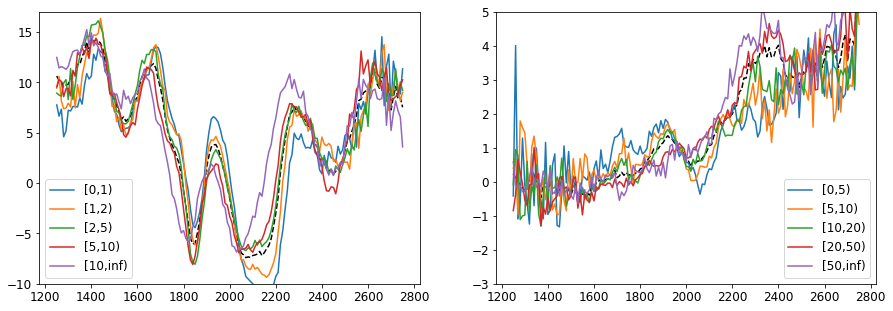

In [17]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(Lz, VZ, XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,1,2,5,10,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
lims = [0,5,10,20,50,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VZ[ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-3,5)

0 1 8406828 1987512
1 2 8406828 1207311
2 5 8406828 2024617
5 10 8406828 1499114
10 inf 8406828 1688274


(-10.0, 17.0)

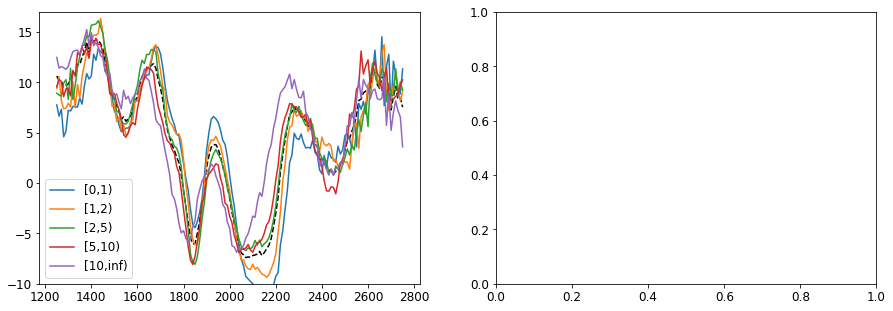

In [141]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

lims = [0,1,2,5,10,float('inf')]
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[0].set_ylim(-10,17)


0 5 8406828 1306976
5 10 8406828 1082950
10 20 8406828 1611349
20 50 8406828 2479735
50 inf 8406828 1925818


(-10.0, 17.0)

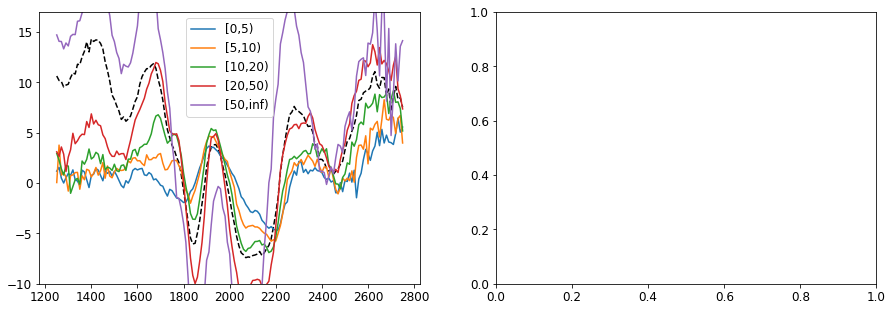

In [178]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

lims = [0,5,10,20,50,float('inf')]
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[0].set_ylim(-10,17)


0.03162277660168379 0.039810717055349734 8319756 21632
0.039810717055349734 0.05011872336272725 8319756 27154
0.05011872336272725 0.06309573444801936 8319756 33948
0.06309573444801936 0.07943282347242822 8319756 42180
0.07943282347242822 0.1000000000000001 8319756 52308
0.1000000000000001 0.12589254117941687 8319756 64385
0.12589254117941687 0.15848931924611157 8319756 79422
0.15848931924611157 0.19952623149688828 8319756 96642
0.19952623149688828 0.25118864315095846 8319756 118034
0.25118864315095846 0.3162277660168386 8319756 142914
0.3162277660168386 0.39810717055349815 8319756 171646
0.39810717055349815 0.5011872336272735 8319756 203718
0.5011872336272735 0.6309573444801949 8319756 239726
0.6309573444801949 0.7943282347242838 8319756 277855
0.7943282347242838 1.000000000000003 8319756 319024
1.000000000000003 1.2589254117941713 8319756 358719
1.2589254117941713 1.584893192461119 8319756 397834
1.584893192461119 1.9952623149688868 8319756 435974
1.9952623149688868 2.51188643150959 8

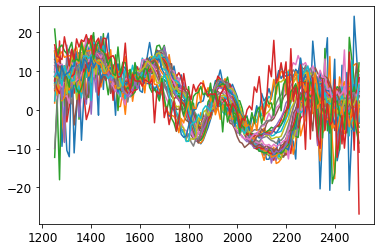

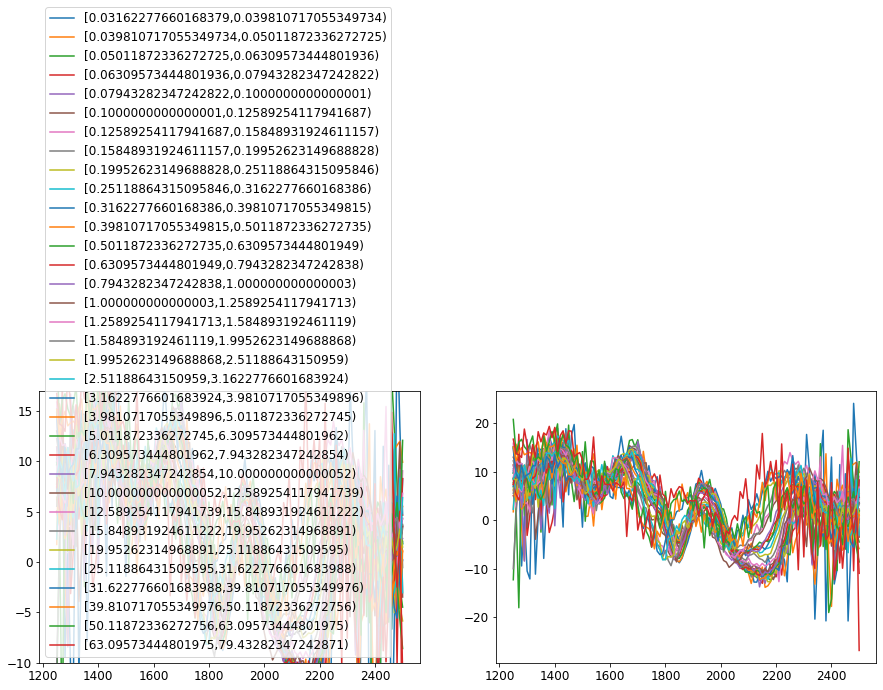

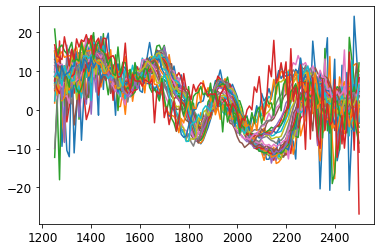

In [122]:
XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

#lims = [0,1,2,5,10,float('inf')]
#lims = [0,0.5,1,1.5,2,3,4,5,7.5,10,15,20,float('inf')]
lims = 10**np.arange(-1.5,2,0.1)
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[0].set_ylim(-10,17)

for c in curves:
    ax[1].plot(nx,c)
    
fd = skfda.FDataGrid(
    data_matrix=curves,
    grid_points=nx,
)

fd.plot()


In [1]:
XMIN = 1250
XMAX = 2500
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

#lims = [0,1,2,5,10,float('inf')]
#lims = [0,0.5,1,1.5,2,3,4,5,7.5,10,15,20,float('inf')]
lims = 10**np.arange(-1.5,2,0.1)
curves = []
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jr) & (Jr < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    curves.append(ny)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[0].set_ylim(-10,17)

for c in curves:
    ax[1].plot(nx,c)
    
fd = skfda.FDataGrid(
    data_matrix=curves,
    grid_points=nx,
)

fd.plot()


NameError: name 'l' is not defined

[0.49416212 0.12257185 0.09377213]
[[-7.37123750e-01  5.00347262e-01  1.00000000e+00]
 [-6.44431991e-01  3.26828635e-01 -1.98635602e-01]
 [-5.97076798e-01  1.99854224e-01 -5.26904193e-01]
 [-5.63443012e-01  2.35583433e-01 -2.04043604e-01]
 [-5.96311875e-01  2.49201551e-01 -3.38145340e-02]
 [-5.60599527e-01  2.35301490e-01 -1.59924743e-02]
 [-5.24087817e-01 -7.59073070e-02 -6.00500636e-02]
 [-4.90917921e-01  9.56270204e-02  2.29633612e-02]
 [-4.65356779e-01  1.20367471e-01 -8.14929168e-02]
 [-4.88867507e-01  4.22400462e-02  2.98925647e-02]
 [-4.16187338e-01 -8.84879681e-02 -9.55487556e-02]
 [-4.32416074e-01  1.17619843e-02 -2.14884057e-02]
 [-4.00179722e-01 -5.21828266e-02  1.35947680e-02]
 [-3.27976078e-01 -1.29275252e-01 -5.54267979e-02]
 [-2.94823336e-01 -1.74188737e-01 -1.46306630e-02]
 [-2.51358512e-01 -1.64008958e-01  2.04516540e-02]
 [-1.93301050e-01 -2.24845973e-01  1.88866008e-03]
 [-1.14349308e-01 -2.20711607e-01 -7.75325311e-04]
 [-2.71951211e-02 -2.80367322e-01  1.89109959e-

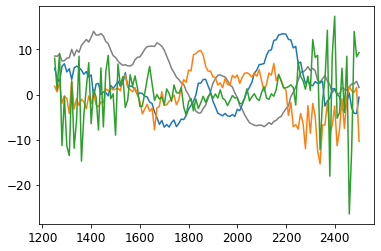

In [181]:

#basis = BSpline(n_basis=50)
#basis_fd = fd.to_basis(basis)
#bfd_grid = basis_fd.to_grid(nx).data_matrix[:,:,0]
#basis_fd.plot()

#fpca = FPCA(n_components=2)
fpca = FPCA(n_components=3)
weights = fpca.fit_transform(fd)
comps = fpca.components_.data_matrix[:,:,0]
#comps = fpca.components_.to_grid(x).data_matrix
#comps = comps[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal
#print(weights)

plt.plot(nx, fd.data_matrix.mean(axis=0), c='gray')
for c in comps:
    plt.plot(nx,c)
print(weights)

#bfd_mean = bfd_grid.mean(axis=0)
#plt.plot(x, bfd_mean, c='k')
#i = 4
#plt.plot(x, bfd_mean + weights[i] @ comps)
#plt.plot(x, ps[i])

[0.62121269 0.14075705]
[[-0.73123375  0.28387304]
 [-0.66098493  0.45157966]
 [-0.61661749  0.37652182]
 [-0.58383968  0.2808722 ]
 [-0.61130675  0.25332987]
 [-0.58353634  0.27797079]
 [-0.54078103 -0.0642819 ]
 [-0.5116553   0.10676746]
 [-0.48935142  0.16425183]
 [-0.48878037  0.06267762]
 [-0.44073081 -0.04781204]
 [-0.45746842  0.01772901]
 [-0.42338328 -0.06886701]
 [-0.34444008 -0.12968967]
 [-0.3163944  -0.18019132]
 [-0.26295073 -0.18697887]
 [-0.20836733 -0.28904668]
 [-0.11687084 -0.26710986]
 [-0.02909123 -0.33808229]
 [ 0.08120509 -0.34241906]
 [ 0.15806192 -0.32253822]
 [ 0.17969419 -0.25341463]
 [ 0.2107853  -0.22096076]
 [ 0.25365787 -0.25122866]
 [ 0.33990102 -0.4088095 ]
 [ 0.51442044 -0.50478936]
 [ 0.70065847 -0.48977507]
 [ 0.67926287 -0.30979364]
 [ 0.73698148 -0.10225589]
 [ 0.88230347  0.0713092 ]
 [ 0.98160559  0.36023669]
 [ 0.91600472  0.47309615]
 [ 0.78324177  0.59782908]
 [ 1.          1.        ]]


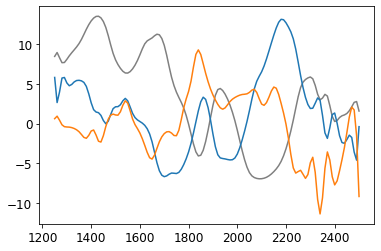

In [123]:

basis = BSpline(n_basis=50)
basis_fd = fd.to_basis(basis)
bfd_grid = basis_fd.to_grid(nx).data_matrix[:,:,0]
#basis_fd.plot()

#fpca = FPCA(n_components=2)
fpca = FPCA(n_components=2, components_basis=BSpline(n_basis=50))
weights = fpca.fit_transform(basis_fd)
#comps = fpca.components_.data_matrix[:,:,0]
comps = fpca.components_.to_grid(nx).data_matrix
comps = comps[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal

bfd_mean = bfd_grid.mean(axis=0)
plt.plot(nx, bfd_mean, c='gray')
for c in comps:
    plt.plot(nx,c)
print(weights)


#bfd_mean = bfd_grid.mean(axis=0)
#plt.plot(nx, bfd_mean, c='k')
#i = 4
#plt.plot(nx, bfd_mean + weights[i] @ comps)
#plt.plot(nx, ps[i])

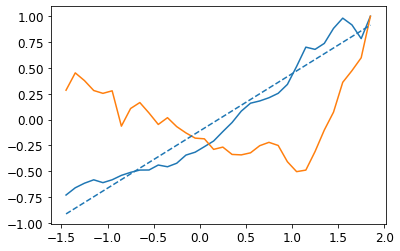

In [124]:
logjz = (np.log10(lims[:-1]) + np.log10(lims[1:]))/2
cw = weights[:,0]
plt.plot(logjz, cw)
plt.plot(logjz, weights[:,1])
fm, fn = np.polyfit(logjz, cw, 1)
plt.plot(logjz, fm*logjz+fn, c='C0', ls='--')

comp = comps[0,:]

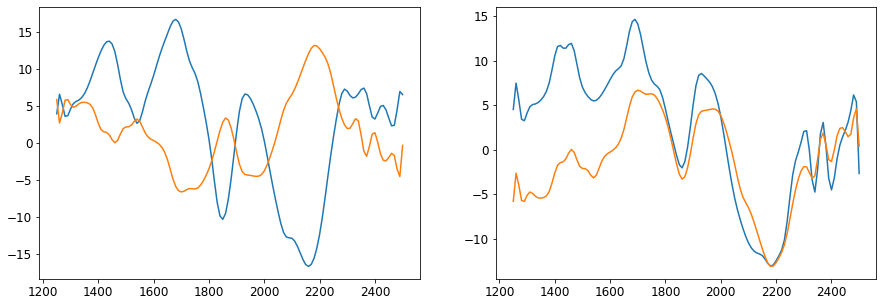

In [125]:

fig, ax = plt.subplots(1,2,figsize=(15,5))

remean = bfd_mean.copy()
reweights = weights.copy()
for i in range(len(comps)):
    remean += np.min(weights[:,i]) * comps[i]
    reweights[:,i] = weights[:,i] - np.min(weights[:,i])

#plt.plot(nx, bfd_mean)
ax[0].plot(nx, remean)
ax[0].plot(nx, comps[0])

ax[1].plot(nx, remean+np.max(weights[:,0])*comps[i])
ax[1].plot(nx, -comps[0])


[  1  19  43  68 104 111 118 124]
[  1  21  45  72 105 112 119 124]


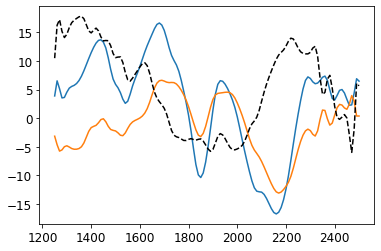

In [231]:
#plt.plot(nx, remean)
#plt.plot(nx, -comps[0])
from scipy.signal import find_peaks
meanpeaks = find_peaks(remean)[0]
comppeaks = find_peaks(-comps[0])[0]
comppeaks = comppeaks[(comppeaks != 50) & (comppeaks != 6)]
print(meanpeaks)
print(comppeaks)
#plt.plot(nx[meanpeaks], remean[meanpeaks], '.')
#plt.plot(nx[comppeaks], -comps[0][comppeaks], '.')

sh = np.mean(nx[comppeaks] - nx[meanpeaks])
shifted = np.interp(nx, nx-sh,-comps[0])
plt.plot(nx, remean)
plt.plot(nx, shifted)
plt.plot(nx, remean-2.1*shifted, c='k', ls='--')

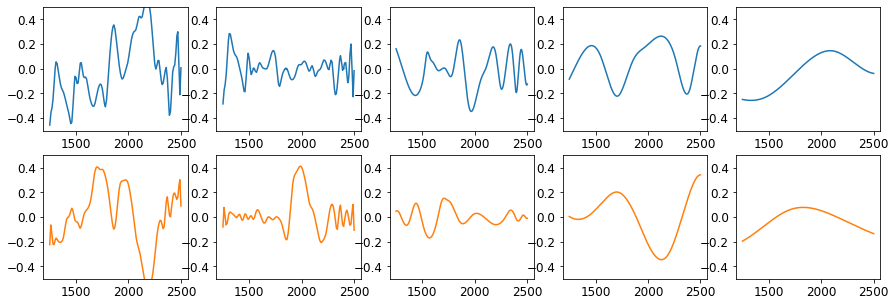

In [142]:
YLIM = 0.5
fig, ax = plt.subplots(2,5,figsize=(15,5))
xpol, ypol = curve_from_bins(nx, -remean+np.max(weights[:,0])*comps[i], N)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
ax[0][0].plot(xpol, ypol, c=f'C0')
ax[0][0].set_ylim(-YLIM,YLIM)
imf = emd.sift.sift(ypol)
for i in range(imf.shape[1]):
    ax[0][i+1].plot(xpol, imf[:,i], c=f'C0')
    ax[0][i+1].set_ylim(-YLIM,YLIM)
    
xpol, ypol = curve_from_bins(nx, -comps[0], N)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
ax[1][0].plot(xpol, ypol, c=f'C1')
ax[1][0].set_ylim(-YLIM,YLIM)
imf = emd.sift.sift(ypol)
for i in range(imf.shape[1]):
    ax[1][i+1].plot(xpol, imf[:,i], c=f'C1')
    ax[1][i+1].set_ylim(-YLIM,YLIM)

0.5539806364320536 0.6204376265268625


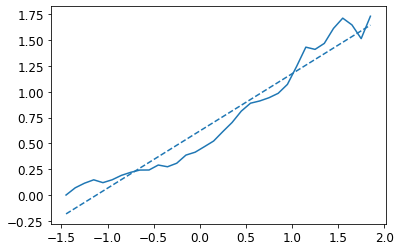

In [187]:
logjz = (np.log10(lims[:-1]) + np.log10(lims[1:]))/2
cw = reweights[:,0]
plt.plot(logjz, cw)
fm, fn = np.polyfit(logjz, cw, 1)
plt.plot(logjz, fm*logjz+fn, c='C0', ls='--')
print(fm,fn)

comp = comps[0,:]

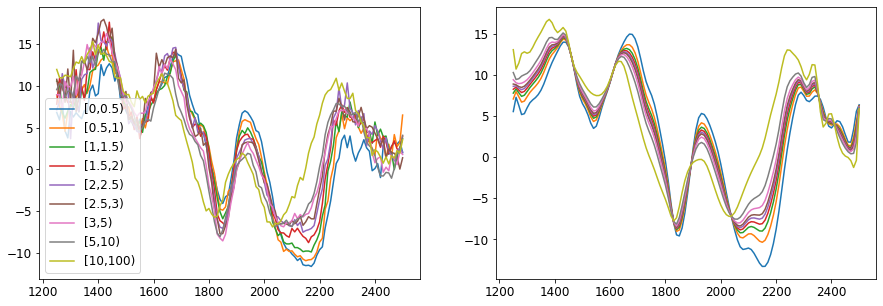

In [189]:

fig, ax = plt.subplots(1,2,figsize=(15,5))

#tjz = 15
nlims = [0,0.5,1,1.5,2,2.5,3,5,10,100]

for low, high in zip(nlims[:-1],nlims[1:]):
    ind = (low <= Jz) & (Jz < high)
    #print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    
    tjz = fm*np.log10((low+high)/2) + fn
    rec = remean + tjz*comp
    ax[1].plot(nx, rec)

ax[0].legend()

[141.40426033 132.7055933   98.2000746    5.02083126 -26.50244395
  17.21541445 -35.9078415   81.94241685 -24.93890315 -23.84171512
   1.3845522   14.7304545   15.71556036  -2.81634934  13.76911862
  11.17174829  -6.36836641   4.59961838   5.09111308   9.46488602
  -0.26357053]
[141.40426033 132.7055933   98.2000746    0.           0.
   0.           0.          81.94241685   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]


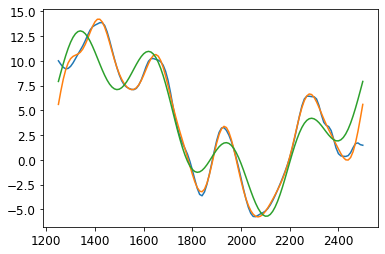

In [622]:
tgm = remean+np.max(weights[:,0])*comps[i]
#tgm -= np.mean(tgm)
plt.plot(nx, tgm)
basis = Fourier(n_basis=20)
tgmf = skfda.FDataGrid(tgm, nx).to_basis(basis)
ncoef = tgmf.coefficients.copy()[0]
csum = np.abs(ncoef).sum()
print(ncoef)
ncoef[np.abs(ncoef)/csum < 0.1] = 0
print(ncoef)
plt.plot(nx, np.transpose(tgmf.basis.evaluate(nx)[:,:,0]) @ tgmf.coefficients[0])
plt.plot(nx, np.transpose(tgmf.basis.evaluate(nx)[:,:,0]) @ ncoef)


[0.64650074 0.14372238]
[[-0.70082376  0.2702703 ]
 [-0.65090632  0.42220998]
 [-0.61554654  0.36676376]
 [-0.59052605  0.26982525]
 [-0.61843771  0.26569489]
 [-0.5806352   0.27827387]
 [-0.55305107 -0.04353118]
 [-0.49912413  0.15347168]
 [-0.49949667  0.1649288 ]
 [-0.49308312  0.07248299]
 [-0.45235433 -0.0429115 ]
 [-0.45942834  0.03749569]
 [-0.42911553 -0.06488325]
 [-0.34584847 -0.1282803 ]
 [-0.32366163 -0.17790086]
 [-0.27017839 -0.19544612]
 [-0.21298    -0.28971427]
 [-0.11866009 -0.27391872]
 [-0.02802283 -0.34436443]
 [ 0.07879482 -0.35559212]
 [ 0.1582346  -0.33060563]
 [ 0.17938728 -0.26437669]
 [ 0.21216368 -0.22494494]
 [ 0.25795801 -0.25288142]
 [ 0.33977433 -0.41459387]
 [ 0.51990912 -0.52236923]
 [ 0.70716558 -0.50887185]
 [ 0.67974301 -0.31976903]
 [ 0.74539396 -0.10193312]
 [ 0.88998484  0.08950579]
 [ 0.9852778   0.38416914]
 [ 0.91559867  0.48739099]
 [ 0.77249449  0.5944054 ]
 [ 1.          1.        ]]


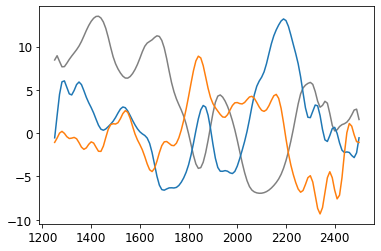

In [459]:

basis = BSpline(n_basis=50)
basis_fd = fd.to_basis(basis)
bfd_grid = basis_fd.to_grid(nx).data_matrix[:,:,0]
#basis_fd.plot()

#fpca = FPCA(n_components=2)
#cbasis = Fourier(n_basis=100, domain_range=(XMIN-(XMAX-XMIN), XMAX+(XMAX-XMIN)))
cbasis = Fourier(n_basis=40)
fpca = FPCA(n_components=2, components_basis=cbasis)
weights = fpca.fit_transform(basis_fd)
#comps = fpca.components_.data_matrix[:,:,0]
comps = fpca.components_.to_grid(nx).data_matrix
comps = comps[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal

bfd_mean = bfd_grid.mean(axis=0)
plt.plot(nx, bfd_mean, c='gray')
for c in comps:
    plt.plot(nx,c)
print(weights)

#bfd_mean = bfd_grid.mean(axis=0)
#plt.plot(nx, bfd_mean, c='k')
#i = 4
#plt.plot(nx, bfd_mean + weights[i] @ comps)
#plt.plot(nx, ps[i])


[0.85782027 0.07329707]
[[-0.85268223 -0.84402034]
 [-0.46161087  0.38886674]
 [-0.00958939  1.        ]
 [ 0.32388249 -0.02109066]
 [ 1.         -0.52375574]]


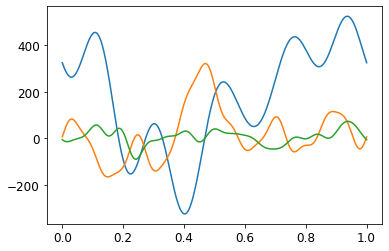

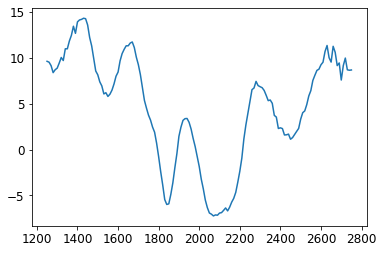

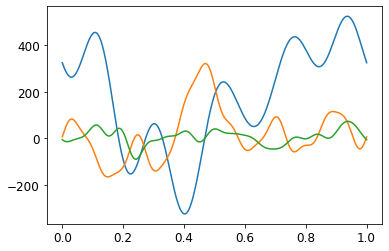

In [385]:

basis = Fourier(n_basis=200)
basis_fd = fd.to_basis(basis)
bfd_grid = basis_fd.to_grid(nx).data_matrix[:,:,0]
#basis_fd.plot()

#fpca = FPCA(n_components=2)
#cbasis = Fourier(n_basis=100, domain_range=(XMIN-(XMAX-XMIN), XMAX+(XMAX-XMIN)))
cbasis = Fourier(n_basis=50)
fpca = FPCA(n_components=2, components_basis=cbasis)
weights = fpca.fit_transform(basis_fd)
#comps = fpca.components_.data_matrix[:,:,0]
comps = fpca.components_.to_grid(nx).data_matrix
comps = comps[:,:,0]
print(fpca.explained_variance_ratio_)

rescal = np.max(np.abs(weights), axis=0)
comps = comps*rescal[:,np.newaxis]
weights = weights/rescal
print(weights)

#bfd_mean = bfd_grid.mean(axis=0)
#plt.plot(nx, bfd_mean, c='gray')
#for c in comps:
#    plt.plot(nx,c)
#print(weights)

#bfd_mean = bfd_grid.mean(axis=0)
#plt.plot(nx, bfd_mean, c='k')
#i = 4
#plt.plot(nx, bfd_mean + weights[i] @ comps)
#plt.plot(nx, ps[i])

COEFF_CUTOFF = 0.02
bfd_mean = bfd_grid.mean(axis=0)
mean_coeffs=skfda.FDataGrid([bfd_mean], nx).to_basis(cbasis).coefficients[0]
plt.plot(nx,bfd_mean)
mean_coeffs[np.abs(mean_coeffs) < np.abs(mean_coeffs).sum()*COEFF_CUTOFF] = 0
ncoef = [mean_coeffs]
comp_coeffs = fpca.components_.coefficients * rescal[:,np.newaxis]
for row in comp_coeffs:
    cut = np.abs(row).sum() * COEFF_CUTOFF
    row[np.abs(row)<cut] = 0
    ncoef.append(row)
    
ncomps = skfda.FDataBasis(basis=cbasis, coefficients=ncoef)
ncomps.plot()


0.9724740390902786
0.9999999999999983
-3.0580336083051515e-15
-6.8686307807588065e-15
1.76003828354409e-15

1.0244446362034914
0.4203186570162214
0.9999999999999907
6.239443228322885e-15
2.0326999520603464e-14

1.045617765886553
-0.06866203413288437
0.21392605548370466
0.9999999999999849
1.3185860583272936e-14

1.0068526758306668
-0.34691295841419983
-0.40311387390119263
-0.39748494142481505
0.9999999999999408

0.9506108829890111
-1.0047436644691434
-0.8108121815825652
-0.6025150585752579
-1.0000000000000955



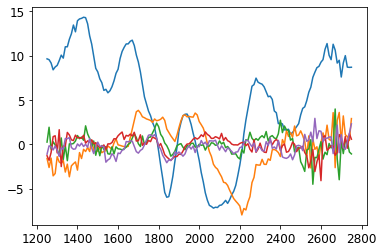

In [244]:
#import itertools
#mc = np.array(curves).mean(axis=0)
##plt.plot(nx, mc)
#nc = np.array([c-mc for c in curves])
##plt.plot(nx, nc.mean(axis=0), c='k')
#nnc = []
#for i in itertools.combinations(range(len(curves)), len(curves)-1):
#    nm = nc[list(i)].mean(axis=0)
#    plt.plot(nx, nm)
##for c in curves:
##    plt.plot(nx, c-mc)

basis = [np.array(curves).mean(axis=0)]

def proj(u,v):
    return (np.dot(u,v) / np.dot(u,u)) * u

#roc = [curves[3], curves[2], curves[4], curves[1]]
#roc = curves[-1:1:-1]
roc = curves[:-1]
for c in roc:
    nb = c.copy()
    for bv in basis:
        nb -= proj(bv, c)
    basis.append(nb)
    
nbasis = [v/np.linalg.norm(v) for v in basis]

for bv in basis:
    plt.plot(nx, bv)

#rbasis = [np.mean(nbasis[0:2],axis=0), np.mean(nbasis[2:5],axis=0)]
#for i in range(len(rbasis)):
#    plt.plot(nx, curves[i] - np.linalg.norm(curves[i])*rbasis[i])
for c in curves:
    for bv in basis:
        print(np.dot(c,bv)/np.dot(bv,bv))
    print()

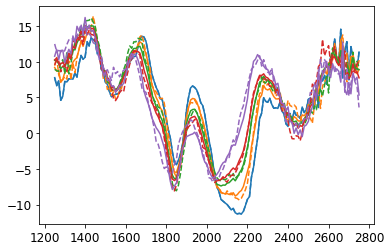

In [246]:
rbasis = [basis[0], basis[1]]

for i,c in enumerate(curves):
    rc = np.zeros(len(c))
    for bv in rbasis:
        rc += np.dot(c,bv)/np.dot(bv,bv) * bv
    plt.plot(nx, c, c=f'C{i}', ls='--')
    plt.plot(nx, rc, c=f'C{i}')

0 0.001 8406828 3083857
0.001 0.002 8406828 1482265
0.002 0.005 8406828 2003746
0.005 0.01 8406828 1065081
0.01 inf 8406828 771879
0 0.005 8406828 2328684
0.005 0.01 8406828 1551877
0.01 0.02 8406828 1815985
0.02 0.05 8406828 1928157
0.05 inf 8406828 782125


(-30.0, 30.0)

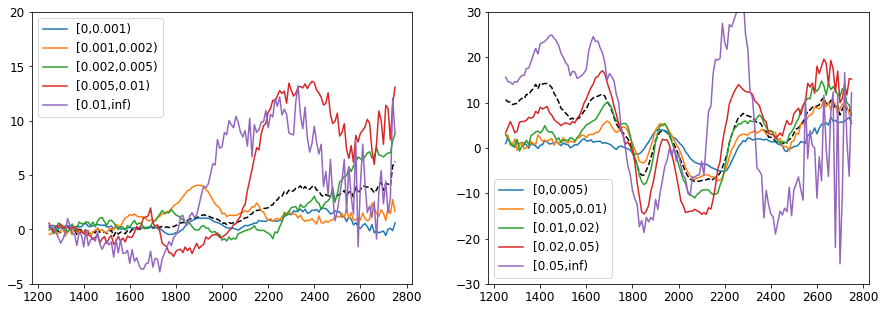

In [20]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VZ, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,.001,.002,.005,.01,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jzn) & (Jzn < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VZ[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
lims = [0,.005,.01,.02,.05,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jrn) & (Jrn < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-5,25)
ax[1].set_ylim(-30,30)

8406828 2388436
0 0.001 8406828 3083857
0.001 0.002 8406828 1482265
0.002 0.005 8406828 2003746
0.005 0.01 8406828 1065081
0.01 inf 8406828 771879


(-10.0, 17.0)

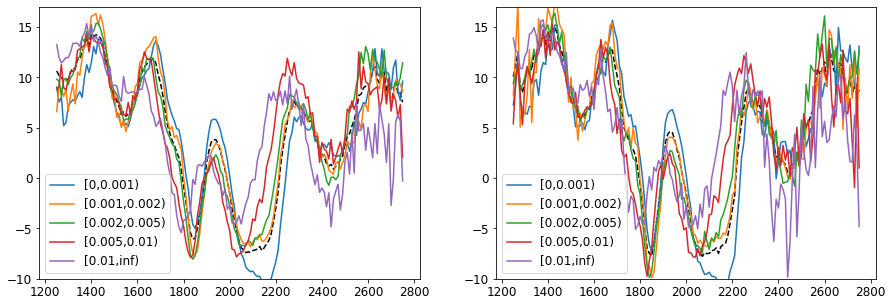

In [33]:
XMIN = 1250
XMAX = 2750

source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')
phir = abs(phi) < 0.25*np.pi
print(len(phir), phir.sum())
nx, ny = smooth_bins(Lz[phir], VR[phir], XMIN, XMAX, 10)
ax[1].plot(nx,ny,c='k',ls='--')

lims = [0,.001,.002,.005,.01,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= Jzn) & (Jzn < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
    nx, ny = smooth_bins(Lz[phir & ind], VR[phir & ind], XMIN, XMAX, 10)
    ax[1].plot(nx,ny,label=f'[{low},{high})')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-10,17)

-inf -0.5 8406828 1949477
-0.5 0 8406828 2367354
0 0.5 8406828 2249888
0.5 inf 8406828 1840109


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-10.0, 17.0)

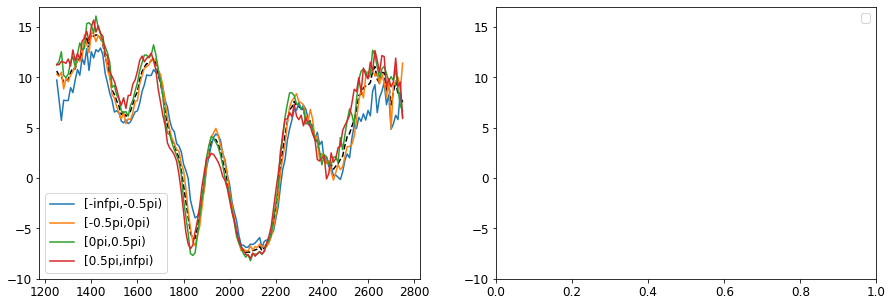

In [32]:
XMIN = 1250
XMAX = 2750

source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

Jnorm = np.sqrt(Jphi**2 + Jz**2 + Jr**2)
Jphin, Jzn, Jrn = Jphi/Jnorm, Jz/Jnorm, Jr/Jnorm
Lzc = Jphi

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

lims = [float('-inf'),-.5,0,.5,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low*np.pi <= phi) & (phi < high*np.pi)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
    ax[0].plot(nx,ny,label=f'[{low}pi,{high}pi)')
#ind = (lims[0]*np.pi > phi) | (phi > lims[-1]*np.pi)
#print('Other', len(ind), ind.sum())
#nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
#ax[0].plot(nx,ny,label=f'Other')

ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-10,17)

In [10]:
#oo = Table.read('APOGEE_DR17_MASTER_Dec2022.fits', format='fits')
#print(source_id)
idst = Table([source_id], names=['source_id'], dtype=['long'])
oo = oo[oo['GaiaEDR3_sourceID'] > 0]

path = 'o_galpy/agesGDR3RVS_clean.fits'
ot = Table.read(path, format='fits')
joined = join(ot, oo, keys_left=['source_id'], keys_right=['GaiaEDR3_sourceID'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 2 168661 3309
2 4 168661 9883
4 8 168661 29432
8 inf 168661 20877


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

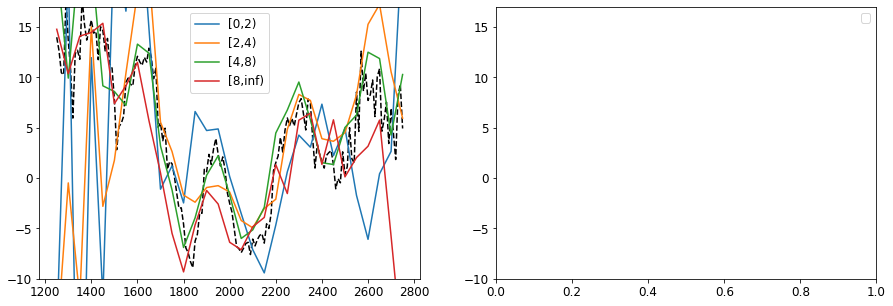

In [22]:
ages = np.array(joined['Chemical_Age_Dec2022'])
Lz = np.array(-joined['Vphi'] * joined['R'])
VR = np.array(joined['VR'])

XMIN = 1250
XMAX = 2750

#source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 

fig, ax = plt.subplots(1,2,figsize=(15,5))
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, 10)
ax[0].plot(nx,ny,c='k',ls='--')

lims = [0,2,4,8,float('inf')]
for low, high in zip(lims[:-1],lims[1:]):
    ind = (low <= ages) & (ages < high)
    print(low, high, len(ind), ind.sum())
    nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 50)
    ax[0].plot(nx,ny,label=f'[{low},{high})')
#ind = (lims[0]*np.pi > phi) | (phi > lims[-1]*np.pi)
#print('Other', len(ind), ind.sum())
#nx, ny = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 10)
#ax[0].plot(nx,ny,label=f'Other')

ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-10,17)
ax[1].set_ylim(-10,17)
ax[0].xlabel('Lz')
ax[0].xlabel('VR')
plt.savefig('ages_chemical_age.png')

[ 0.8488057 13.126201   3.6035028 ...  9.908494  12.370237  10.965867 ]
[1.2418181 4.419656  6.644401  ... 3.668815  5.7122135 5.6814747]


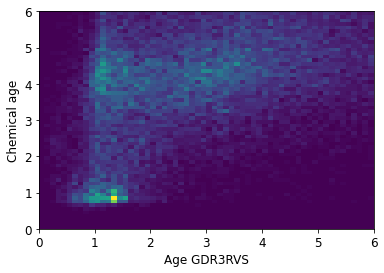

In [24]:
ages = np.array(joined['Chemical_Age_Dec2022'])
oldages = np.array(joined['age'])
Lz = np.array(-joined['Vphi'] * joined['R'])
VR = np.array(joined['VR'])

nnan = ~(np.isnan(ages))
print(ages[nnan])
print(oldages[nnan])
plt.hist2d(oldages[nnan], ages[nnan], bins=60, range=[[0,6],[0,6]]);
plt.xlabel('Age GDR3RVS')
plt.ylabel('Chemical age')
plt.savefig('ages_comparison.png')

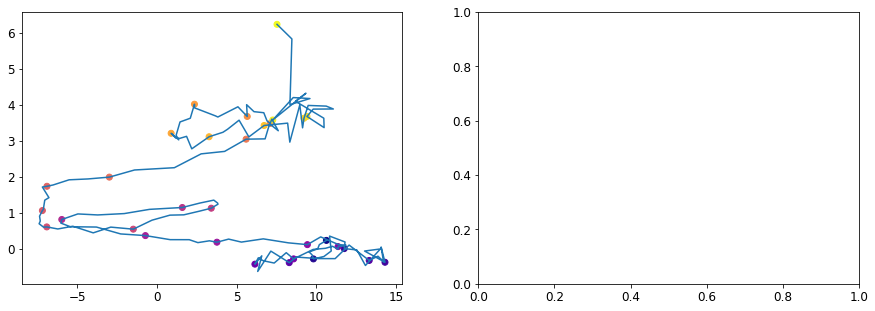

In [170]:
XMIN = 1250
XMAX = 2750
source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = l.load_data_actions(XMIN, XMAX, np.pi) 
fig, ax = plt.subplots(1,2,figsize=(15,5))

Lzb, nx = smooth_bins(Lz, VR, XMIN, XMAX, 10)
Lzb, ny = smooth_bins(Lz, VZ, XMIN, XMAX, 10)

ax[0].plot(nx,ny)
ax[0].scatter(nx[::5], ny[::5], c=Lzb[::5], cmap='plasma')

In [5]:
path = 'actions_both.fits'
oo = Table.read(path, format='fits')

path = 'o_galpy/agesGDR3RVS_clean.fits'
ot = Table.read(path, format='fits')
joined = join(ot, oo, keys_left=['source_id'], keys_right=['source_id'])

['VR_1', 'Vphi_1', 'VZ_1', 'X_1', 'Y_1', 'Z_1', 'R_1', 'phi_1', 'source_id_1', 'Teff', 'logg', 'meta', 'age', 'age_error', 'VR_2', 'Vphi_2', 'VZ_2', 'X_2', 'Y_2', 'Z_2', 'R_2', 'phi_2', 'source_id_2', 'e_med_dgeo', 'Zmax_med_dgeo', 'Jr_med_dgeo', 'Jz_med_dgeo', 'rperi_med_dgeo', 'rapo_med_dgeo', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi']


(0.0, 50.0)

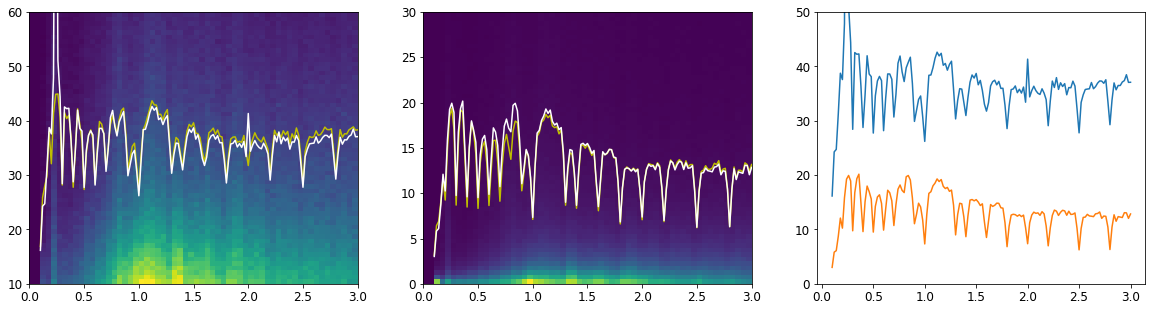

In [106]:
print(joined.keys())

fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].hist2d(np.array(joined['age']),np.array(joined['JR']),range=((0,3),(10,60)), bins=60);
nx, ny = smooth_bins(joined['age'], joined['Jr_med_dgeo'], 0.1, 3, 0.02, median=False)
ax[0].plot(nx,ny,c='y')
nx, ny = smooth_bins(joined['age'], joined['JR'], 0.1, 3, 0.02, median=False)
ax[0].plot(nx,ny,c='w')
ax[0].set_ylim(10,60)

ax[1].hist2d(np.array(joined['age']),np.array(joined['JZ']),range=((0,3),(0,30)), bins=60);
nx, ny = smooth_bins(joined['age'], joined['Jz_med_dgeo'], 0.1, 3, 0.02, median=False)
ax[1].plot(nx,ny,c='y')
nx, ny = smooth_bins(joined['age'], joined['JZ'], 0.1, 3, 0.02, median=False)
ax[1].plot(nx,ny,c='w')
ax[1].set_ylim(0,30)

nx, ny = smooth_bins(joined['age'], joined['JR'], 0.1, 3, 0.02, median=False)
ax[2].plot(nx,ny)
nx, ny = smooth_bins(joined['age'], joined['JZ'], 0.1, 3, 0.02, median=False)
ax[2].plot(nx,ny)
ax[2].set_ylim(0,50)

['VR_1', 'Vphi_1', 'VZ_1', 'X_1', 'Y_1', 'Z_1', 'R_1', 'phi_1', 'source_id_1', 'Teff', 'logg', 'meta', 'age', 'age_error', 'VR_2', 'Vphi_2', 'VZ_2', 'X_2', 'Y_2', 'Z_2', 'R_2', 'phi_2', 'source_id_2', 'e_med_dgeo', 'Zmax_med_dgeo', 'Jr_med_dgeo', 'Jz_med_dgeo', 'rperi_med_dgeo', 'rapo_med_dgeo', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi']


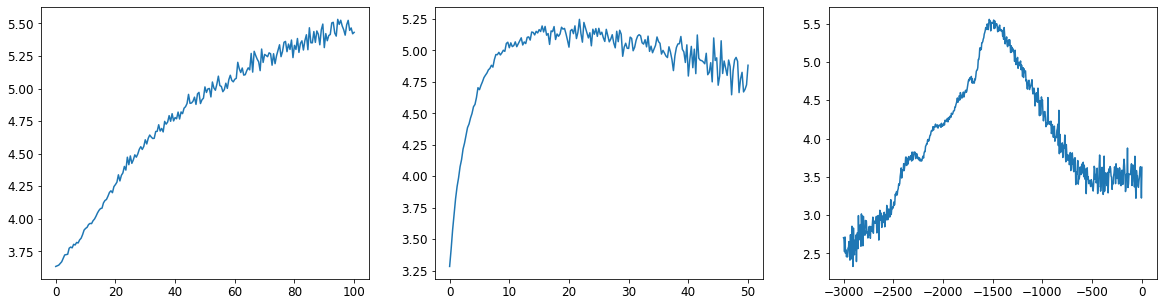

In [113]:
print(joined.keys())

fig, ax = plt.subplots(1,3,figsize=(20,5))

nx, ny = smooth_bins(joined['JR'], joined['age'], 0, 100, 0.5, median=True)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(joined['JZ'], joined['age'], 0, 50, 0.25, median=True)
ax[1].plot(nx,ny)

nx, ny = smooth_bins(joined['JPhi'], joined['age'], -3000, 0, 5, median=True)
ax[2].plot(nx,ny)

In [117]:
oo = Table.read('APOGEE_DR17_MASTER_Dec2022.fits', format='fits')
oo = oo[oo['GaiaEDR3_sourceID'] > 0]

path = 'actions_both.fits'
ot = Table.read(path, format='fits')

joined = join(ot, oo, keys_left=['source_id'], keys_right=['GaiaEDR3_sourceID'])

(0.0, 50.0)

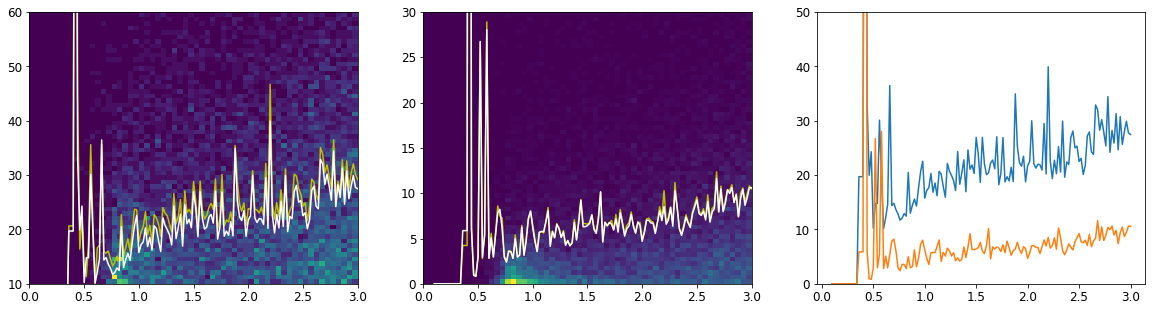

In [119]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
age_col = 'Chemical_Age_Dec2022'

ax[0].hist2d(np.array(joined[age_col]),np.array(joined['JR']),range=((0,3),(10,60)), bins=60);
nx, ny = smooth_bins(joined[age_col], joined['Jr_med_dgeo'], 0.1, 3, 0.02, median=False)
ax[0].plot(nx,ny,c='y')
nx, ny = smooth_bins(joined[age_col], joined['JR'], 0.1, 3, 0.02, median=False)
ax[0].plot(nx,ny,c='w')
ax[0].set_ylim(10,60)

ax[1].hist2d(np.array(joined[age_col]),np.array(joined['JZ']),range=((0,3),(0,30)), bins=60);
nx, ny = smooth_bins(joined[age_col], joined['Jz_med_dgeo'], 0.1, 3, 0.02, median=False)
ax[1].plot(nx,ny,c='y')
nx, ny = smooth_bins(joined[age_col], joined['JZ'], 0.1, 3, 0.02, median=False)
ax[1].plot(nx,ny,c='w')
ax[1].set_ylim(0,30)

nx, ny = smooth_bins(joined[age_col], joined['JR'], 0.1, 3, 0.02, median=False)
ax[2].plot(nx,ny)
nx, ny = smooth_bins(joined[age_col], joined['JZ'], 0.1, 3, 0.02, median=False)
ax[2].plot(nx,ny)
ax[2].set_ylim(0,50)

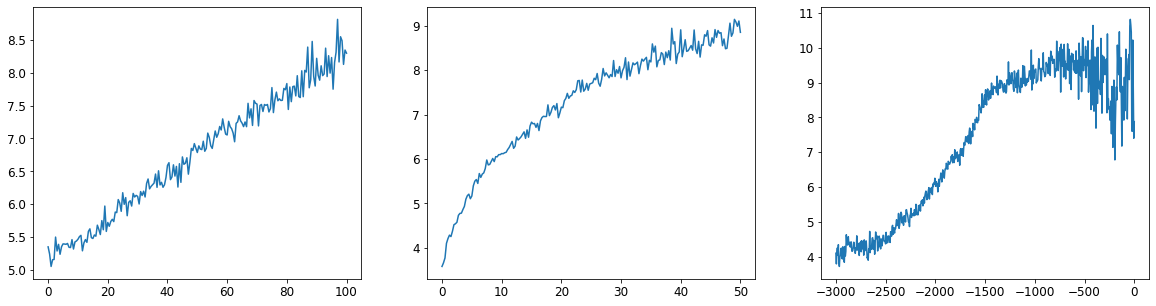

In [120]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
age_col = 'Chemical_Age_Dec2022'

#ax[0].hist2d(np.array(joined['JR']),np.array(joined['age']),range=((10,60),(0,3)), bins=60);
nx, ny = smooth_bins(joined['JR'], joined[age_col], 0, 100, 0.5, median=False)
ax[0].plot(nx,ny)

nx, ny = smooth_bins(joined['JZ'], joined[age_col], 0, 50, 0.25, median=False)
ax[1].plot(nx,ny)

nx, ny = smooth_bins(joined['JPhi'], joined[age_col], -3000, 0, 5, median=False)
ax[2].plot(nx,ny)